## Prediction
Upload models in sequence, append their predictions in sequence, and then evaluate required results

1. [done] Deterministic write pipeline for producing df w [mean, std, actual]
2. [done] Train ensemble
3. [done] Bayesian write pipeline for producing df w [epistemic, aleatoric, total_uncertainty, expectation, variance, actual]
4. Produce plot showing the selective prediction w uncertainty thresholding
5. Produce plot showing histology slide with companion aleatoric, epistemic, and total

RE 4. and 5. : "Outputs would include <br>
    a. revised uncertainty thresholding curves (i.e. , selective prediction), and <br>
    b. a few histopathology slides visualised, whereby each slide is shown 4 views: (1) RBG image, (2) mean estimate for each spot, (3) aleatoric uncertainty, (4) epistemic uncertainty"

Note that the quality of calculating the two separate components of uncertainty is contingent on the assumption that gene expressions are distributed following the negative binomial likelihood. 

Point I am unsure of: 
I understand it that the expectation of the posterior predictive will be closer to the true mean, regardless of whether the likelihood is or is not actually NB. However, I am not certain about this point since I have only read vague commentary about it. It would be nice to know and word this point properly, since if it is true, I think it is an appealing property of Bayesian inference. 

Enjoy the weekend

In [1]:
from pathlib import Path
from anndata import read_h5ad
import sys
import scanpy
import os
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.stats import nbinom, pearsonr

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
# stimage custom 
file = Path("../stimage").resolve() # path to src code
parent = file.parent
sys.path.append(str(parent))

from tqdm import tqdm

from stimage._utils import gene_plot, Read10X, ReadOldST, tiling
from stimage._model import CNN_NB_multiple_genes, negative_binomial_layer, negative_binomial_loss
from stimage._data_generator import DataGenerator

import pickle

In [2]:
import seaborn as sns
sns.set_theme(style="whitegrid")

## Constants

In [3]:
DATA_PATH = Path("/scratch/smp/uqsmac12/dataset_breast_cancer_9visium")

OUT_PATH = Path("/scratch/smp/uqsmac12/results")

OUT_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
gene_list=["COX6C","TTLL12", "PABPC1", "GNAS", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]

## Data loader

In [5]:
(DATA_PATH / "all_adata.h5ad").exists()

True

In [6]:
adata_all = read_h5ad(DATA_PATH / "all_adata.h5ad")

The annadata object `adata_all` contains STexpression readings for each spot (represented in a spotXexpression matrix). The bellow script accesses cell attribute information and updates the path.

In [7]:
# update metadata for annadata such that it maps to the correct location
adata_all.obs["tile_path"] = adata_all.obs.tile_path.map(
    lambda x: x.replace("/clusterdata/uqxtan9/Xiao/breast_cancer_9visium",
                        "/scratch/smp/uqsmac12/dataset_breast_cancer_9visium"))

In [8]:
adata_all.obs["tile_path"][0]

'/scratch/smp/uqsmac12/dataset_breast_cancer_9visium/tiles/1142243F-12601-4511-299.jpeg'

In [9]:
# remove FFPE and 1160920F --- the test set
adata_all_train_valid = adata_all[adata_all.obs["library_id"].isin(
    adata_all.obs.library_id.cat.remove_categories(["FFPE", "1160920F"]).unique())]

In [10]:
n_genes = len(gene_list)

training_index = adata_all_train_valid.obs.sample(frac=0.7, random_state=1).index
training_dataset = adata_all_train_valid[training_index,].copy()

valid_index = adata_all_train_valid.obs.index.isin(training_index)
valid_dataset = adata_all_train_valid[~valid_index,].copy()

test_index = adata_all.obs.library_id == "FFPE"
test_dataset_1 = adata_all[test_index,].copy()

test_index = adata_all.obs.library_id == "1160920F"
test_dataset_2 = adata_all[test_index,].copy()

In [11]:
train_gen = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=training_dataset, 
                          genes=gene_list, aug=False),
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
train_gen_ = train_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
valid_gen = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=valid_dataset, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
valid_gen_ = valid_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_gen_1 = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_dataset_1, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__1 = test_gen_1.batch(1)
test_gen_2 = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=test_dataset_2, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__2 = test_gen_2.batch(1)

In [47]:
for d in test_gen__1:
    break

In [48]:
x, y = d[0], d[1]

In [51]:
y

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.944439]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.6931472]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.890349]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.4849067]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.0794415]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.3978953]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.1271343]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.7917595]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.6390574]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.3672957]], d

In [49]:
x.shape

TensorShape([1, 299, 299, 3])

## Get results from ensembles

In [15]:
def get_samples_stats_geneid(np_preds, list_genes, k=1):
    """
    """
    # mean and var functions of k...
    nb_mean = lambda n, p, k: n*(1-p*k)/(p*k)
    nb_var = lambda n, p, k: n*(1-p*k)/(p*p*k*k)
    
    res = []
    for gene_idx, gene_name in enumerate(list_genes):
        
        # predicted NB params 
        n, p = np_preds[gene_idx][:,0], np_preds[gene_idx][:,1]
        # mean (with p corrected by k factor)
        mu = nb_mean(n, p, k)
        # var (with p corrected by k factor)
        var = nb_var(n, p, k)
        
        res.append(np.stack([n, p, mu, var], axis=1))
        
    return np.stack(res, axis=2)

In [ ]:
ensemble_results1 = []
ensemble_results2 = []

for e_id in tqdm(range(11)):
    e_id # += 1
    print(f"Ensemble id {e_id}")
    # load model
    model = None
    file_model = str(OUT_PATH / f'resnet50_{e_id}-rev1.h5')
    model = load_model(file_model, 
                       custom_objects={
                           'negative_binomial_loss': negative_binomial_loss,
                       }
                      )
    print("loaded")
    # get predictions 
    pred_test_1 = model.predict(test_gen__1)
    print("got preds1")
    pred_test_2 = model.predict(test_gen__2)
    print("got preds2")
    # append results 
    ensemble_results1.append(get_samples_stats_geneid(pred_test_1, gene_list))
    ensemble_results2.append(get_samples_stats_geneid(pred_test_2, gene_list))
    print("appended results")
    
ensemble_results1 = np.stack(ensemble_results1, axis=3)
ensemble_results2 = np.stack(ensemble_results2, axis=3)

  0%|          | 0/11 [00:00<?, ?it/s]

Ensemble id 0
loaded
got preds1


### Save results

In [18]:
ensemble_results1.shape

(2338, 4, 14, 11)

In [19]:
# save out results
with open(str(OUT_PATH / 'ensemble_results_1-rev1.pkl'), 'wb') as file:
    pickle.dump(ensemble_results1, file)
    
with open(str(OUT_PATH / 'ensemble_results_2-rev1.pkl'), 'wb') as file:
    pickle.dump(ensemble_results2, file)

### Save ground truth

### Load results

In [20]:
with open(str(OUT_PATH / 'ensemble_results_1-rev1.pkl'), 'rb') as f:
    ensemble_results1 = pickle.load(f)

with open(str(OUT_PATH / 'ensemble_results_2-rev1.pkl'), 'rb') as f:
    ensemble_results2 = pickle.load(f)

### Load ground truth

In [21]:
with open(str(OUT_PATH / 'df_target_1.pkl'), 'rb') as f:
    df_target_1 = pickle.load(f)

with open(str(OUT_PATH / 'df_target_2.pkl'), 'rb') as f:
    df_target_2 = pickle.load(f)

## understanding `ensemble_results{e_id}`

`ensemble_results1` is a np array with 4 axes: `(samples, [n, p, mu, var], genes, simulations)`

In [22]:
ensemble_results1.shape

(2338, 4, 14, 11)

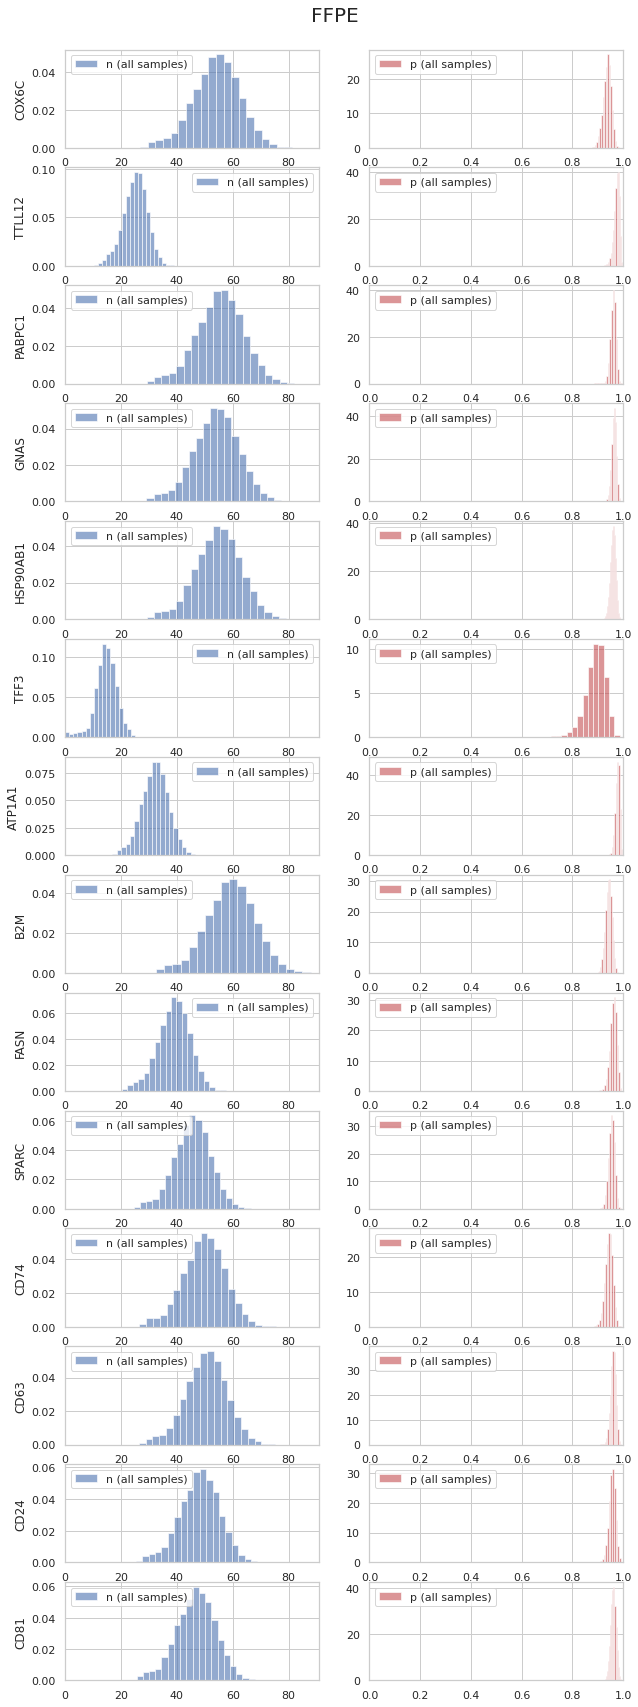

In [23]:
fig, ax = plt.subplots(nrows=len(gene_list), ncols=2, figsize=(10,30))
for gid, gn in enumerate(gene_list):
    
    p_all = ensemble_results1[:, 1, gid, :].reshape(-1)
    n_all = ensemble_results1[:, 0, gid, :].reshape(-1)
    
    ax[gid][0].hist(n_all, bins=20, label='n (all samples)', color='b', alpha=0.6, density=True)
    ax[gid][1].hist(p_all, bins=20, label='p (all samples)', color='r', alpha=0.6, density=True)
    # plt.hist(n_all, bins=100, label='n (all samples)', color='b', alpha=0.6)
    # plt.hist(p_all, bins=100, label='p (all samples)', color='r', alpha=0.6)
    ax[gid][0].set_xlim([0,ensemble_results1[:, 0, :, :].max()])
    ax[gid][1].set_xlim([0,1])
    ax[gid][0].legend()
    ax[gid][1].legend()
    ax[gid][0].set_ylabel(gn)
    
fig.suptitle('FFPE', fontsize=20, y=0.9)
fig.show()

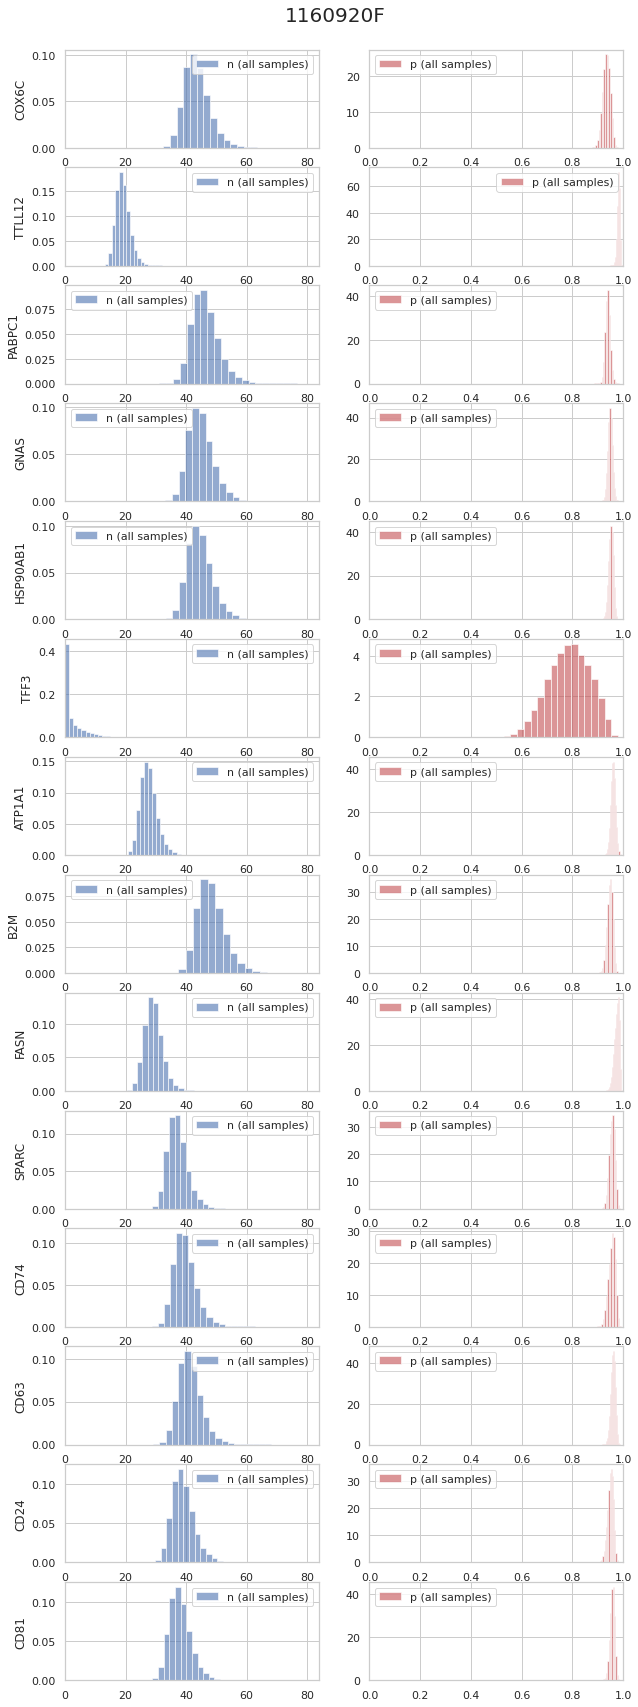

In [24]:
fig, ax = plt.subplots(nrows=len(gene_list), ncols=2, figsize=(10,30))
for gid, gn in enumerate(gene_list):
    
    p_all = ensemble_results2[:, 1, gid, :].reshape(-1)
    n_all = ensemble_results2[:, 0, gid, :].reshape(-1)
    
    ax[gid][0].hist(n_all, bins=20, label='n (all samples)', color='b', alpha=0.6, density=True)
    ax[gid][1].hist(p_all, bins=20, label='p (all samples)', color='r', alpha=0.6, density=True)
    # plt.hist(n_all, bins=100, label='n (all samples)', color='b', alpha=0.6)
    # plt.hist(p_all, bins=100, label='p (all samples)', color='r', alpha=0.6)
    ax[gid][0].set_xlim([0,ensemble_results2[:, 0, :, :].max()])
    ax[gid][1].set_xlim([0,1])
    ax[gid][0].legend()
    ax[gid][1].legend()
    ax[gid][0].set_ylabel(gn)
fig.suptitle('1160920F', fontsize=20, y=.9)
fig.show()

# Obtain uncertainty components
First we need to estimate $\mu_{\theta}(X) = \mathbb{E}[X|\theta]= r(1-p)/p$, as well as $\sigma^2_{\theta}(X) = \mathbb{V}[X|\theta]=r(1-p)/p^2$.

we have the mean and variance of multiple simulations and for multiple correction factors values k... lets test risk shedding for one single k first and then determine the best for all k.

$\mathbb{V}(X) = \mathbb{E}[{\mathbb{V}(X|\theta)}] + \mathbb{V}[{\mathbb{E}(X|\theta)}]$

In [26]:
ensemble_results1.shape

(2338, 4, 14, 11)

In [27]:
def get_uncertainty_components(ens_res):
    """
    """
    # get E[E[X|f]], E[V[X|f]] 
    mean = ens_res[:,-2:,:,:].mean(axis=-1)
    # get V[E[X|f]], V[V[X|f]] 
    var = ens_res[:,-2:,:,:].var(axis=-1)
    # stack E(mean), V(mean), E(var), total
    res = np.stack([mean[:,0,:], var[:,0,:], mean[:,1,:], var[:,0,:]+mean[:,1,:]], axis=1)
    
    return res

In [28]:
np_total_var1 = get_uncertainty_components(ensemble_results1)
np_total_var2 = get_uncertainty_components(ensemble_results2)

# Sanity check across all samples

## ...for `FFPE`

In [29]:
df_target_1.head(2)

,COX6C,TTLL12,PABPC1,GNAS,HSP90AB1,TFF3,ATP1A1,B2M,FASN,SPARC,CD74,CD63,CD24,CD81
AAACAAGTATCTCCCA-1-FFPE,2.944439,0.693147,4.890349,2.484907,2.079442,0.0,2.397895,4.127134,0.000000,1.791759,2.639057,3.367296,3.871201,3.258096
AAACACCAATAACTGC-1-FFPE,1.098612,0.000000,3.044523,2.079442,1.609438,0.0,0.693147,3.610918,0.693147,2.302585,3.555348,2.833213,1.386294,1.791759


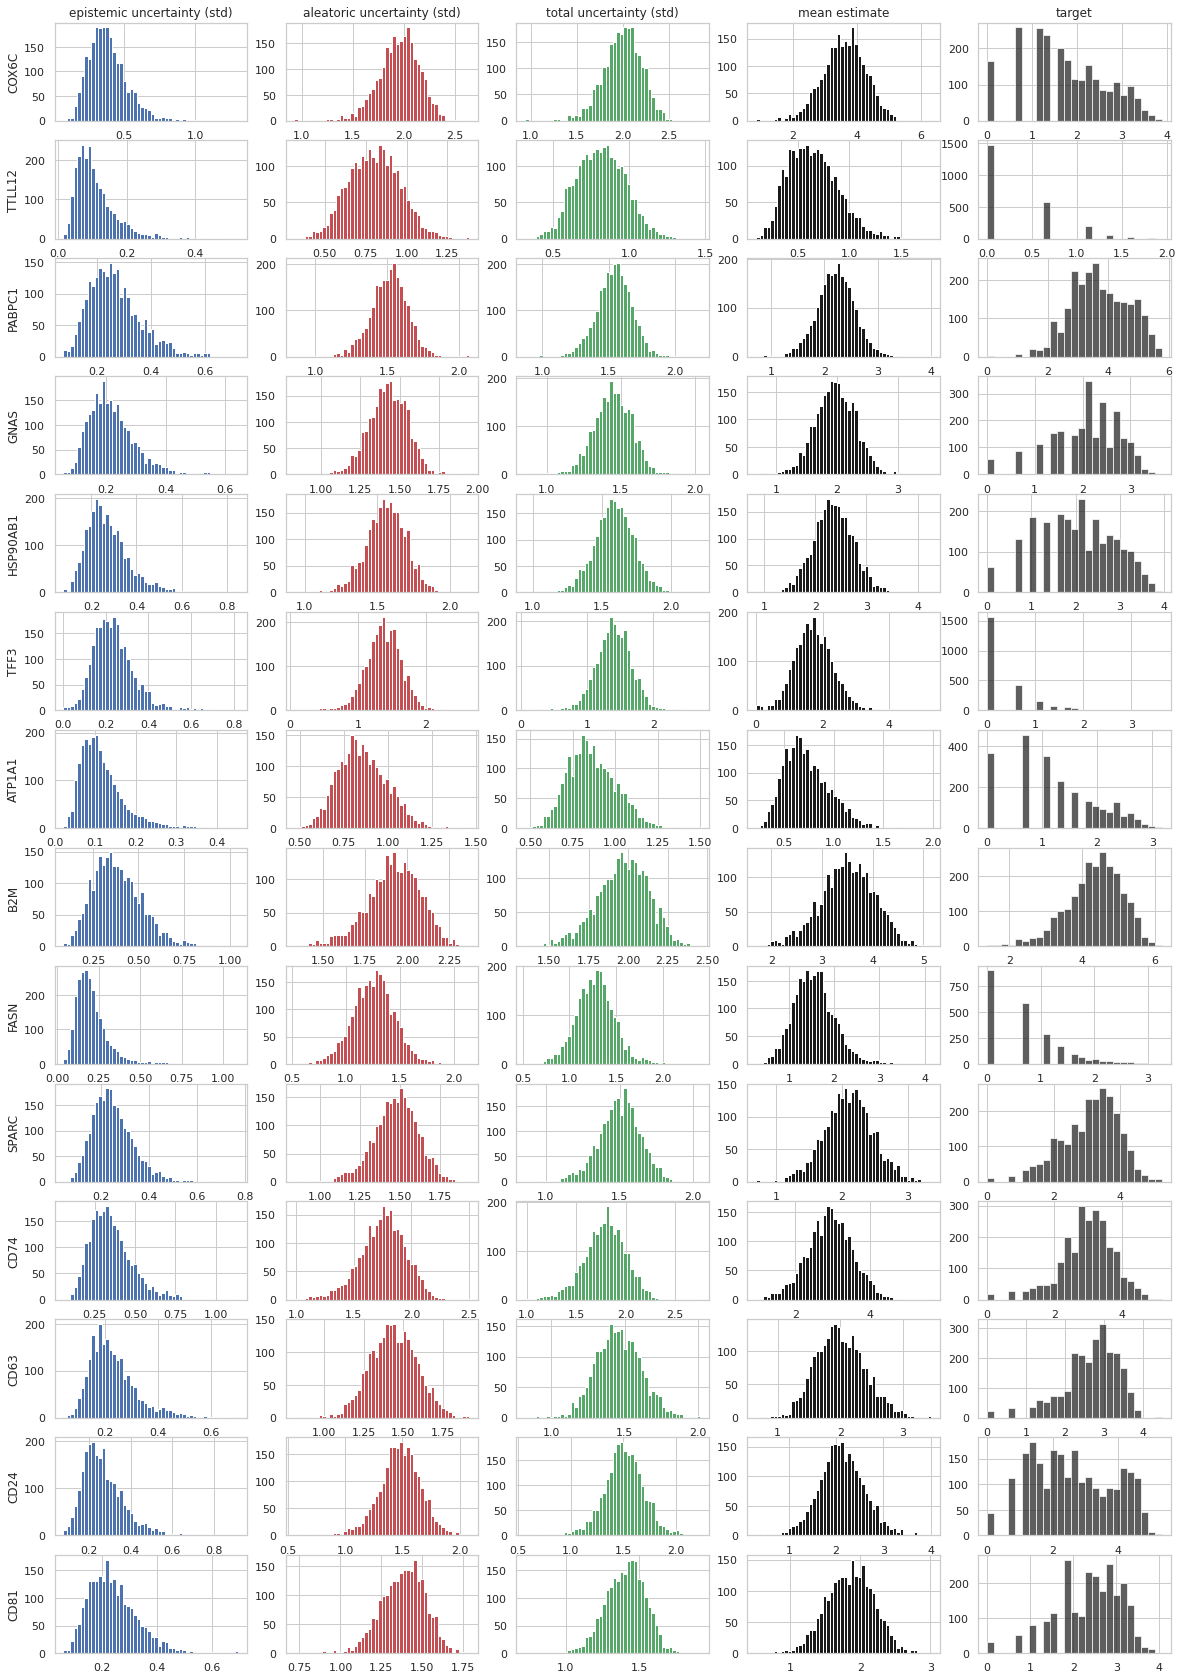

In [30]:
# mean = ensemble_results1[:,-2:,:,:].mean(axis=-1)
# var = ensemble_results1[:,-2:,:,:].var(axis=-1)
# np_total_var = np.stack([mean[:,0,:], var[:,0,:], mean[:,1,:], var[:,0,:]+mean[:,1,:]], axis=1)

# E(mean), V(mean), E(var), total

fig, ax = plt.subplots(nrows=len(gene_list), ncols=5, figsize=(20, 30))

ax[0][0].set_title("epistemic uncertainty (std)")
ax[0][1].set_title("aleatoric uncertainty (std)")
ax[0][2].set_title("total uncertainty (std)")
ax[0][3].set_title("mean estimate")
ax[0][4].set_title("target")

for gid, gname in enumerate(gene_list):
    ax[gid][0].set_ylabel(gname)
    ax[gid][0].hist(np.sqrt(np_total_var1[:,1,gid]), bins=50, color='b')
    ax[gid][1].hist(np.sqrt(np_total_var1[:,2,gid]), bins=50, color='r')
    ax[gid][2].hist(np.sqrt(np_total_var1[:,3,gid]), bins=50, color='g')
    ax[gid][3].hist(np_total_var1[:,0,gid], bins=50, color='k')
    ax[gid][4].hist(df_target_1[gname], bins=25, color='k', alpha=0.7)
fig.show()

## ...for `1160920F`

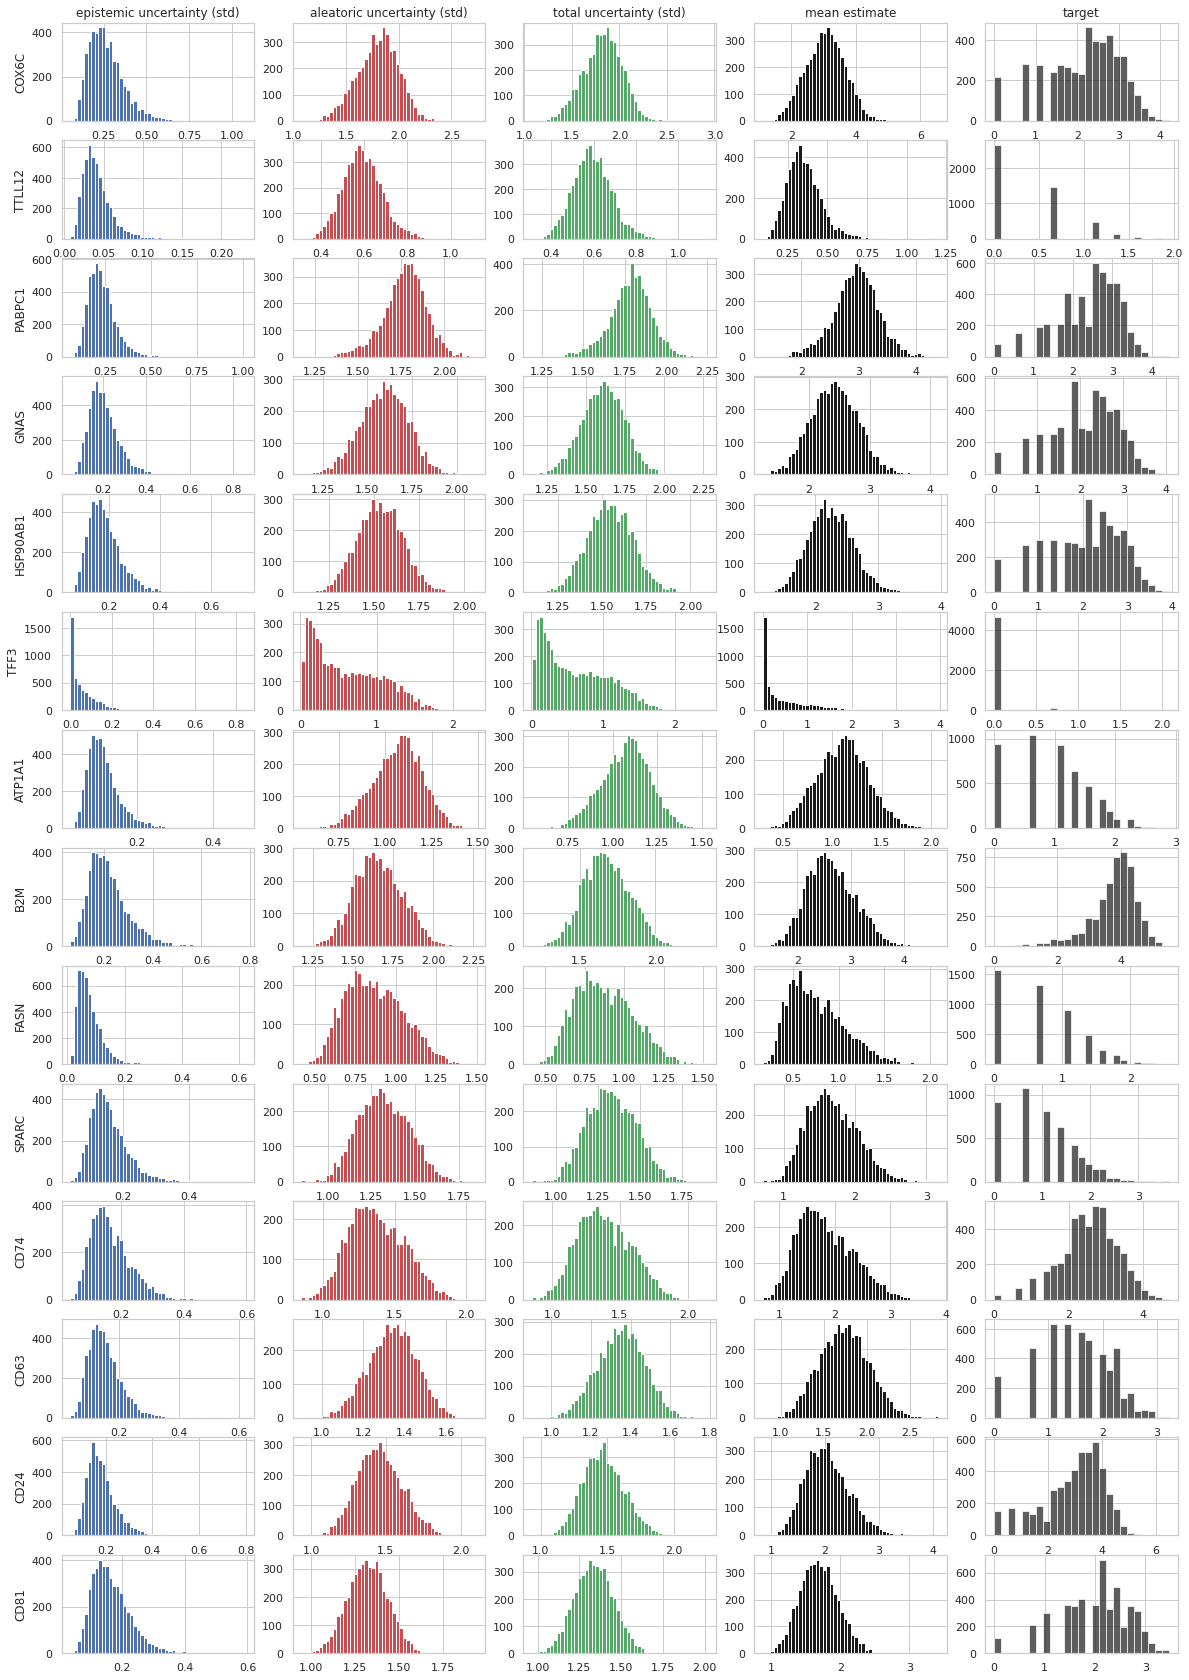

In [31]:
# mean = ensemble_results2[:,-2:,:,:].mean(axis=-1)
# var = ensemble_results2[:,-2:,:,:].var(axis=-1)
# np_total_var = np.stack([mean[:,0,:], var[:,0,:], mean[:,1,:], var[:,0,:]+mean[:,1,:]], axis=1)

# E(mean), V(mean), E(var), total

fig, ax = plt.subplots(nrows=len(gene_list), ncols=5, figsize=(20, 30))

ax[0][0].set_title("epistemic uncertainty (std)")
ax[0][1].set_title("aleatoric uncertainty (std)")
ax[0][2].set_title("total uncertainty (std)")
ax[0][3].set_title("mean estimate")
ax[0][4].set_title("target")

for gid, gname in enumerate(gene_list):
    ax[gid][0].set_ylabel(gname)
    ax[gid][0].hist(np.sqrt(np_total_var2[:,1,gid]), bins=50, color='b')
    ax[gid][1].hist(np.sqrt(np_total_var2[:,2,gid]), bins=50, color='r')
    ax[gid][2].hist(np.sqrt(np_total_var2[:,3,gid]), bins=50, color='g')
    ax[gid][3].hist(np_total_var2[:,0,gid], bins=50, color='k')
    ax[gid][4].hist(df_target_2[gname], bins=25, color='k', alpha=.7)
    
fig.show()

In [161]:
m1_res_1 = ensemble_results1[:,2,:,2]

(2338, 14)

## Performance of individual models, for `FFPE`

In [42]:
dict_corr_ffpe = {g: [] for g in gene_list}
for m in range(10):
    # select the prediction, E(mean), and model, m
    m1_res_1 = ensemble_results1[:,0,:,m]
    
    for i, g in enumerate(gene_list):
        dict_corr_ffpe[g].append(pearsonr(df_target_1[g], m1_res_1[:, i])[0])

df_corr_ffpe = pd.DataFrame(dict_corr_ffpe)
df_corr_ffpe

df_ffpe = pd.concat([df_corr_ffpe.mean(), df_corr_ffpe.std()], axis=1)
df_ffpe.columns = ['mean', 'std']
df_ffpe

,mean,std
COX6C,0.348640,0.019659
TTLL12,0.176775,0.024569
PABPC1,0.382091,0.018769
GNAS,0.391062,0.011920
HSP90AB1,0.385154,0.018653
TFF3,0.091651,0.020995
ATP1A1,0.351124,0.026086
B2M,0.361469,0.011923
FASN,0.255307,0.009739
SPARC,0.149620,0.018164


## Performance of individual models, `1160920F`

In [53]:
ensemble_results2.shape

(4783, 4, 14, 11)

In [44]:
dict_corr_s2 = {g: [] for g in gene_list}
for m in range(10):
    
    # select the prediction, E(mean), and model, m
    m1_res_2 = ensemble_results2[:,0,:,m]
    
    for i, g in enumerate(gene_list):
        dict_corr_s2[g].append(pearsonr(df_target_2[g], m1_res_2[:, i])[0])

df_corr_s2 = pd.DataFrame(dict_corr_s2)
df_corr_s2

df_s2 = pd.concat([df_corr_s2.mean(), df_corr_s2.std()], axis=1)
df_s2.columns = ['mean', 'std']
df_s2

,mean,std
COX6C,0.096341,0.025985
TTLL12,-0.033036,0.028618
PABPC1,0.121548,0.041208
GNAS,0.129424,0.032686
HSP90AB1,0.121564,0.025658
TFF3,0.052047,0.002192
ATP1A1,0.205044,0.026740
B2M,0.011814,0.037889
FASN,-0.051272,0.029725
SPARC,-0.172780,0.009295


In [39]:
df_corr_ffpe.std()

COX6C       0.019659
TTLL12      0.024569
PABPC1      0.018769
GNAS        0.011920
HSP90AB1    0.018653
TFF3        0.020995
ATP1A1      0.026086
B2M         0.011923
FASN        0.009739
SPARC       0.018164
CD74        0.010676
CD63        0.015693
CD24        0.018689
CD81        0.012637
dtype: float64

In [ ]:
# # this is uploaded above
# # ground truth / target information
# df_target_1 = test_dataset_1.to_df().loc[:, gene_list]
# df_target_2 = test_dataset_2.to_df().loc[:, gene_list]

In [54]:
# append targets to predictions
np_target1 = df_target_1.values.reshape(len(df_target_1), 1, len(df_target_1.columns))
np_total_var1 = np.append(np_total_var1, np_target1, axis=1)

np_target2 = df_target_2.values.reshape(len(df_target_2), 1, len(df_target_2.columns))
np_total_var2 = np.append(np_total_var2, np_target2, axis=1)

In [55]:
dict_res1 = {g: np_total_var1[:,:,i] for i, g in enumerate(gene_list)}
dict_res2 = {g: np_total_var2[:,:,i] for i, g in enumerate(gene_list)}

In [56]:
list_dfs1 = []
for g in dict_res1.keys():
    df = pd.DataFrame(dict_res1[g], columns=['mean', 'epistemic', 'aleatoric', 'total', 'actual'])
    df['gene_name'] = g
    list_dfs1.append(df)
df_res1 = pd.concat(list_dfs1, axis=0)

list_dfs2 = []
for g in dict_res2.keys():
    df = pd.DataFrame(dict_res2[g], columns=['mean', 'epistemic', 'aleatoric', 'total', 'actual'])
    df['gene_name'] = g
    list_dfs2.append(df)
df_res2 = pd.concat(list_dfs2, axis=0)

In [57]:
df_res1.head(2)

,mean,epistemic,aleatoric,total,actual,gene_name
0,3.157081,0.190603,3.305968,3.496571,2.944439,COX6C
1,3.493685,0.102785,3.735849,3.838634,1.098612,COX6C


In [58]:
df_res2.head(2)

,mean,epistemic,aleatoric,total,actual,gene_name
0,4.059605,0.166927,4.45373,4.620656,0.000000,COX6C
1,3.692304,0.131095,3.98354,4.114635,0.693147,COX6C


In [59]:
df_res1['sample_name'] = 'FFPE'
df_res2['sample_name'] = '1160920F'

In [60]:
df_res = pd.concat([df_res1, df_res2], axis=0)

In [61]:
df_res.shape

(99694, 7)

In [53]:
df_res.head(2)

,mean,epistemic,aleatoric,total,actual,gene_name,sample_name
0,3.264449,0.356792,3.558751,3.915543,2.944439,COX6C,FFPE
1,3.660281,0.328427,4.163891,4.492318,1.098612,COX6C,FFPE


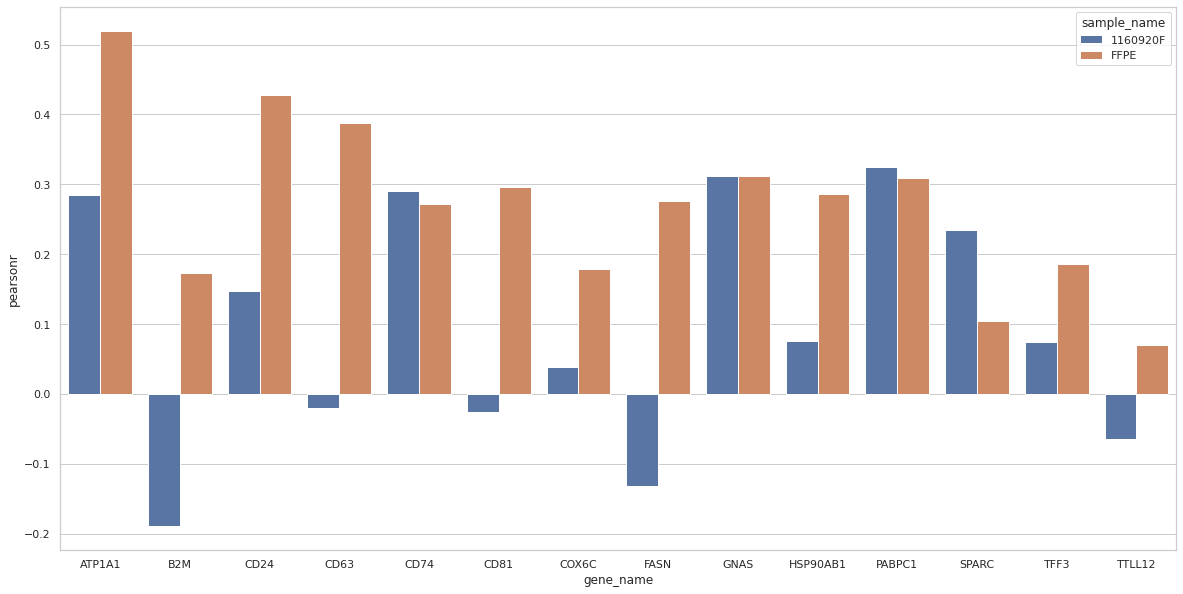

In [62]:
# pearsonr(df_res_all['target'], df_res_all['mean'])
df_sample_gene = df_res.groupby(['sample_name', 'gene_name']).apply(lambda x: pearsonr(x['actual'], x['mean'])[0])
df_sample_gene.name = 'pearsonr'
df_sample_gene = df_sample_gene.reset_index()

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x="gene_name", y="pearsonr", hue="sample_name", data=df_sample_gene, ax=ax)
fig.show()

In [64]:
df_res.head(2)

,mean,epistemic,aleatoric,total,actual,gene_name,sample_name
0,3.157081,0.190603,3.305968,3.496571,2.944439,COX6C,FFPE
1,3.493685,0.102785,3.735849,3.838634,1.098612,COX6C,FFPE


In [67]:
df_res_ffpe = df_res.loc[df_res.sample_name == 'FFPE', ].copy()

In [68]:
dict_corr_genes = {}
for g in gene_list:
    df_ = df_res_ffpe.loc[df_res_ffpe.gene_name == g,:]
    dict_corr_genes[g] = pearsonr(df_['actual'], df_['mean'])[0]
sr_correlations_gene_ffpe = pd.Series(dict_corr_genes,)

In [69]:
# what is the correlation of the mean predictor?
sr_mean_ = df_res_ffpe.groupby('gene_name')['actual'].mean()

df_res_ffpe['mean_pred'] = df_res_ffpe['gene_name'].apply(lambda x: sr_mean_[x])

pearsonr(df_res_ffpe['mean_pred'], df_res_ffpe['actual'])

(0.8225559694474094, 0.0)

<AxesSubplot:>

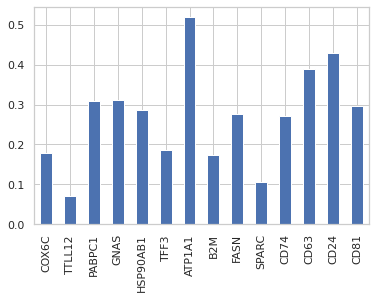

In [70]:
sr_correlations_gene_ffpe.plot.bar()

In [86]:
df_correlations_gene_ffpe

,COX6C,TTLL12,PABPC1,GNAS,HSP90AB1,TFF3,ATP1A1,B2M,FASN,SPARC,CD74,CD63,CD24,CD81
0,1.538435e-01,0.055776,1.812005e-01,2.757381e-01,2.366861e-01,2.489440e-01,4.920678e-01,1.677009e-01,3.019957e-01,0.064396,3.142338e-01,3.015430e-01,4.052342e-01,2.517394e-01
1,7.468318e-14,0.006984,1.046128e-18,4.597234e-42,3.951759e-31,2.323991e-34,7.784128e-143,3.285650e-16,1.682809e-50,0.001838,9.593998e-55,2.394182e-50,4.126877e-93,4.018083e-35


In [71]:
df_sample = df_res.groupby(['sample_name']).apply(lambda x: pearsonr(x['actual'], x['mean'])[0])
df_sample.name = 'pearsonr'
df_sample = df_sample.reset_index()

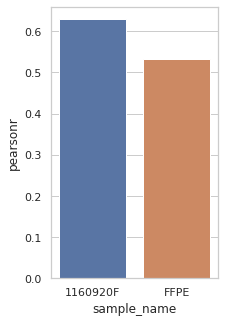

In [72]:
fig, ax = plt.subplots(figsize=(3,5))
sns.barplot(x="sample_name", y="pearsonr", data=df_sample, ax=ax)
fig.show()

In [73]:
df_sample.head()

,sample_name,pearsonr
0,1160920F,0.622512
1,FFPE,0.515410


In [89]:
df_res.groupby(['sample_name']).apply(lambda x: pearsonr(x['actual'], x['mean'])[0]).mean()

0.5689612171123308

In [69]:
# get predictions 
pred_test_1 = model.predict(test_gen__1)
pred_test_2 = model.predict(test_gen__2)

NameError: name 'model' is not defined

In [30]:
pred_test_1[0].shape

(2338, 2)

In [ ]:
pred_test_1.shape

In [32]:
res = get_samples_stats_geneid(pred_test_1, gene_list)

In [33]:
res.shape

(2338, 4, 14)

In [114]:
def get_results(df_target, np_preds, list_genes):
    
    # instantiate dictionary
    dict_results = {}
    
    for gene_idx, gene_name in enumerate(list_genes):
        
        # actual 
        target = df_target[gene_name]

        # predicted NB params 
        n, p = np_preds[gene_idx][:,0], np_preds[gene_idx][:,1]
        
        # mean, var, std 
        mu, var = nbinom.stats(n, p, moments='mv')
        std = np.sqrt(var)

        # create dataframe
        df_temp = pd.DataFrame(
            data=np.stack([mu, var, std, target], axis=1), 
            columns=['mean', 'var', 'std', 'target'],
            index= df_target.index
        )
        
        # append dictionary
        dict_results[gene_name] = df_temp
        
    return dict_results

In [135]:
tf.random.set_seed()

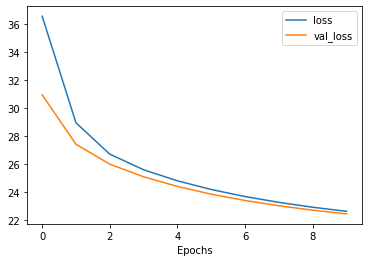

In [22]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

In [34]:
test_dataset_1??

In [45]:
# TO DO

# 1. deterministic write pipeline for producing df w [mean, std, actual]
# 1.5. train ensemble
# 2. Bayesian write pipeline for producing df w [epistemic, aleatoric, total_uncertainty, expectation, variance, actual]
# 3. produce plot showing the selective prediction w uncertainty thresholding
# 4. produce plot showing histology slide with companion aleatoric, epistemic, and total

# 
# Draft results by end of week 2 (Feb-17th)

(2338, 14)

In [ ]:
test_dataset_1

In [89]:
df_temp.head()

,mean,var,std,target
0,2.935439,4.074678,2.018583,2.944439
1,5.838997,11.633478,3.410788,1.098612
2,7.910624,17.247154,4.152969,2.079442
3,4.063245,6.980574,2.642078,1.098612
4,4.097795,6.987684,2.643423,0.693147


In [98]:
df_target = df_target_1.copy()
np_preds = pred_test_1.copy()
list_genes = gene_list.copy()

In [107]:
dict_res1 = get_results(
    df_target = df_target_1, 
    np_preds = pred_test_1,
    list_genes = gene_list
)

In [115]:
dict_res2 = get_results(
    df_target = df_target_2, 
    np_preds = pred_test_2,
    list_genes = gene_list
)

In [128]:
df_res1_all = pd.concat([dict_res1[g] for g in dict_res1.keys()], axis=0)
df_res2_all = pd.concat([dict_res2[g] for g in dict_res2.keys()], axis=0)

In [129]:
df_res_all = pd.concat([df_res1_all, df_res2_all], axis=0)

In [131]:
pearsonr(df_res1_all['target'], df_res1_all['mean'])

(0.2762159394096582, 0.0)

In [132]:
pearsonr(df_res2_all['target'], df_res2_all['mean'])

(0.5736514250260873, 0.0)

In [130]:
pearsonr(df_res_all['target'], df_res_all['mean'])

(0.4494130066977668, 0.0)

In [121]:
pearsonr(dict_res2['COX6C']['mean'], dict_res2['COX6C']['target'])

(-0.1027875138788497, 1.0353204570941155e-12)

In [117]:
dict_res2['COX6C'].head()

,mean,var,std,target
TGGTACCGGCACAGCC-1-1160920F,3.259137,5.483247,2.341633,0.000000
GCGCGTTTAAATCGTA-1-1160920F,2.897606,4.424093,2.103353,0.693147
TGCCTTGCCCTTACGG-1-1160920F,4.820837,9.262687,3.043466,1.098612
GACGACTTTCCAAGAA-1-1160920F,3.893397,6.666375,2.581932,1.791759
CCAGTGAGCTCCTTGT-1-1160920F,1.962099,2.708454,1.645738,0.000000


# SUPERSEDED